<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v4.0.0_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [ ]:
## section: Data manioulation
import math
import pandas as pd
import numpy as np
import random
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [ ]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
  worker = 4
else:
  worker = 0
print('Using device:', device, 'Using number of workers: ', worker)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Step01: Data exploration

In [ ]:
## Download from cifar10
dataset = 'cifar10' # change this one
set_seed(1311)
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

### Exploratory Image analysis

In [ ]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
num_class = len(classes)
print(f"Show of images unique {num_class} labels: ",classes)


### Tranforms to Dataloader

In [ ]:
training_data

In [ ]:
batch_size = 16

## setting the split configuration
set_seed(1311)
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
training_data, val_data = random_split(training_data, [train_size, val_size])

## apply the dataloader
set_seed(1311)

trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )

# check the splitting
num_items_train = len(trainloader.dataset)
num_items_val = len(valloader.dataset)
num_items_test = len(testloader.dataset)

num_batches_train = len(trainloader)
num_batches_val = len(valloader)
num_batches_test = len(testloader)

print("Training set: {} items, {} batches".format(num_items_train, num_batches_train))
print("Validation set: {} items, {} batches".format(num_items_val, num_batches_val))
print("Test set: {} items, {} batches".format(num_items_test, num_batches_test))

### check test set classes distribution

In [ ]:
from collections import Counter

# Assuming testing_data is your test dataset
test_labels = [label for _, label in testing_data]

# Count the occurrences of each class
class_distribution = Counter(test_labels)

# Print the distribution
total_samples = sum(class_distribution.values())
for class_id, count in class_distribution.items():
    percentage = (count / total_samples) * 100
    print(f'Class {classes[class_id]}: {count} samples, {percentage:.2f}% of the test set')

### Review the Batch fig and size

torch.Size([16, 3, 32, 32])


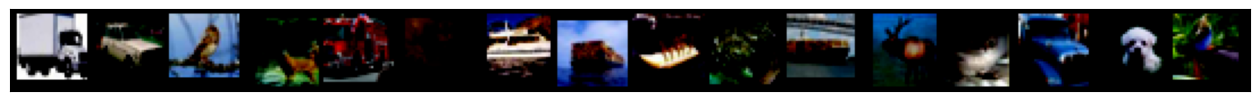

In [8]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [9]:
import time
from tqdm import tqdm

def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train.double() / total_train
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, num_class, class_eva = False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
            if class_eva:
                c = (preds == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

    loss = running_loss / total
    accuracy = correct.double() / total

    if class_eva:
        return loss, accuracy, class_correct, class_total
    else:
        return loss, accuracy

def evaluate(model, dataloader, criterion, device, num_class, class_eva=False, store_examples=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    best_correct = None
    worst_incorrect = None

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

            if store_examples:
                probabilities = F.softmax(outputs, dim=1)
                for i in range(inputs.size(0)):
                    confidence, predicted_label = torch.max(probabilities[i], 0)
                    actual_label = labels[i].item()
                    if predicted_label.item() == actual_label:
                        if best_correct is None or confidence > best_correct['confidence']:
                            best_correct = {
                                'confidence': confidence,
                                'image': inputs[i],
                                'label': actual_label,
                            }
                    else:
                        if worst_incorrect is None or confidence < worst_incorrect['confidence']:
                            worst_incorrect = {
                                'confidence': confidence,
                                'image': inputs[i],
                                'label': actual_label,
                                'predicted_label': predicted_label.item(),
                            }

            if class_eva:
                c = (preds == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

    loss = running_loss / total
    accuracy = correct.double() / total

    results = (loss, accuracy)
    if class_eva:
        results += (class_correct, class_total)
    if store_examples:
        results += (best_correct, worst_incorrect)

    return results

# def display_image(image):
#     # Convert the image tensor to numpy and transpose the dimensions from (C, H, W) to (H, W, C)
#     image = image.cpu().numpy().transpose(1, 2, 0)
#     # Display the image
#     plt.imshow(image)
#     plt.show()

def display_image(image):
    if isinstance(image, dict):
        image = image['image']
    image = image.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.show()

def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, device, num_class, model_name, dataset):

    ## section00: setting path for save the model
    set_seed(1311)
    PATH = f'./{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## section01: Initialize variables
    best_val_acc = 0  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'best_correct': [],
        'worst_incorrect': [],
    }
    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    ## section02: Training and validation the model
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, valloader, criterion, device, num_class)


        # Step the scheduler with the validation loss
        scheduler.step()
        # scheduler.step(val_acc) # for ReduceLROnPlateau

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(100 * train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(100 * val_acc)

        # Save the model if it has improved on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')

        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {100 * train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

    print('Training complete. Evaluating on test set with the best model...')

    ## section03: Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))

    test_loss, test_acc, class_correct, class_total = evaluate(best_model, testloader, criterion, device, num_class, class_eva=True)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {100 * test_acc:.2f}%')
    # Add test results to history
    history['test_loss'] = test_loss
    history['test_accuracy'] = 100 * test_acc

    ## section04: Load the best model for final evaluation on test set for each class
    print(f'Test Acc on each class')
    class_results = {}
    for i in range(num_class):
        if class_total[i] > 0:
            results = 100 * class_correct[i] / class_total[i]
            class_results[classes[i]] = results
            print('Accuracy of class %s : %2d %%' % (classes[i], results))
        else:
            class_results[classes[i]] = 0
            print('Accuracy of class %s : N/A (no samples in test set)' % classes[i])

    history['class_results'] = class_results

    ## section04: collect the best and worst image
    test_loss, test_acc, best_correct, worst_incorrect = evaluate(
        best_model,
        testloader,
        criterion,
        device,
        num_class,
        class_eva=False,
        store_examples=True
    )
    history['best_correct'].append(best_correct)
    history['worst_incorrect'].append(worst_incorrect)
    print('Best Correct Prediction:')
    print('Confidence:', best_correct['confidence'].item())
    # print('Label:', int(best_correct['label']))
    print('Index:',  int(best_correct['label']), "- Labels: ",classes[int(best_correct['label'])])
    display_image(best_correct['image'])

    print('\nWorst Incorrect Prediction:')
    print('Confidence:', worst_incorrect['confidence'].item())
    print('Actual Index:', int(worst_incorrect['label']), "- Labels: ",classes[int(worst_incorrect['label'])])
    print('Predicted Index:', int(worst_incorrect['predicted_label']), "- Labels: ",classes[int(worst_incorrect['predicted_label'])])
    display_image(worst_incorrect['image'])

    return history

## Initialize network

### network: VGG19

In [10]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

### network: Alexnet

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [12]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [13]:
def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_acc(train_acc, val_acc):
    if isinstance(train_acc[0], torch.Tensor):
        train_acc = [x.cpu().numpy() for x in train_acc]
    if isinstance(val_acc[0], torch.Tensor):
        val_acc = [x.cpu().numpy() for x in val_acc]

    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

In [21]:
# set the whole network training
num_epochs = 20
criterion = nn.CrossEntropyLoss()

### Check number of parameter

In [22]:
from torchsummary import summary
for i in [AlexNet(), vgg19(), ResNet18(), ResNet34(), ResNet50()]:
    print("Model: ", i.__class__.__name__)
    print("Number of parameters: ", sum(p.numel() for p in i.parameters() if p.requires_grad))
    summary(i.to(device), (3, 32, 32))
    print("-"*50)

Model:  AlexNet
Number of parameters:  56826698
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 192, 16, 16]         110,784
              ReLU-5          [-1, 192, 16, 16]               0
         MaxPool2d-6            [-1, 192, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]         663,936
              ReLU-8            [-1, 384, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         884,992
             ReLU-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         590,080
             ReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]        

### Train the network - Alexnet

Model will be saved to: ./cifar10_alexnet.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.91it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 1/20, Train Loss: 2.3016, Train Acc: 10.70%, Val Loss: 2.2948, Val Acc: 13.87%, Time: 58.85s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 99.99it/s] 


Model improved and saved to ./cifar10_alexnet.pth
Epoch 2/20, Train Loss: 2.0512, Train Acc: 21.63%, Val Loss: 1.8759, Val Acc: 25.64%, Time: 57.98s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 102.69it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 3/20, Train Loss: 1.7747, Train Acc: 32.12%, Val Loss: 1.7237, Val Acc: 36.28%, Time: 58.22s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 104.93it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 4/20, Train Loss: 1.6117, Train Acc: 39.33%, Val Loss: 1.5452, Val Acc: 41.42%, Time: 58.56s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 94.92it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 5/20, Train Loss: 1.4651, Train Acc: 45.08%, Val Loss: 1.3918, Val Acc: 49.00%, Time: 59.04s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 108.62it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 6/20, Train Loss: 1.3501, Train Acc: 50.43%, Val Loss: 1.2616, Val Acc: 53.85%, Time: 57.58s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 91.27it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 7/20, Train Loss: 1.2475, Train Acc: 54.13%, Val Loss: 1.1462, Val Acc: 57.58%, Time: 59.50s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 109.20it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 8/20, Train Loss: 1.1610, Train Acc: 57.51%, Val Loss: 1.1374, Val Acc: 58.59%, Time: 58.08s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 93.36it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 9/20, Train Loss: 1.0721, Train Acc: 61.14%, Val Loss: 1.0148, Val Acc: 63.92%, Time: 58.93s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 108.45it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 10/20, Train Loss: 1.0046, Train Acc: 63.50%, Val Loss: 0.9596, Val Acc: 65.20%, Time: 58.30s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 89.32it/s] 


Model improved and saved to ./cifar10_alexnet.pth
Epoch 11/20, Train Loss: 0.9387, Train Acc: 66.06%, Val Loss: 0.9729, Val Acc: 65.48%, Time: 59.31s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 109.09it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 12/20, Train Loss: 0.8852, Train Acc: 68.25%, Val Loss: 0.8674, Val Acc: 69.64%, Time: 58.08s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 89.43it/s] 


Epoch 13/20, Train Loss: 0.8446, Train Acc: 69.88%, Val Loss: 0.9077, Val Acc: 68.22%, Time: 58.75s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 107.84it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 14/20, Train Loss: 0.8029, Train Acc: 71.47%, Val Loss: 0.7912, Val Acc: 71.61%, Time: 58.10s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 90.08it/s] 


Model improved and saved to ./cifar10_alexnet.pth
Epoch 15/20, Train Loss: 0.7685, Train Acc: 72.63%, Val Loss: 0.7550, Val Acc: 73.54%, Time: 59.05s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 111.35it/s]


Epoch 16/20, Train Loss: 0.7276, Train Acc: 74.30%, Val Loss: 0.7699, Val Acc: 72.92%, Time: 57.07s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 91.46it/s] 


Model improved and saved to ./cifar10_alexnet.pth
Epoch 17/20, Train Loss: 0.7023, Train Acc: 75.07%, Val Loss: 0.7039, Val Acc: 75.41%, Time: 58.70s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 110.39it/s]


Epoch 18/20, Train Loss: 0.6739, Train Acc: 76.29%, Val Loss: 0.7320, Val Acc: 74.22%, Time: 57.40s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 88.52it/s]


Epoch 19/20, Train Loss: 0.6426, Train Acc: 77.50%, Val Loss: 0.7227, Val Acc: 74.75%, Time: 59.07s


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 111.79it/s]


Model improved and saved to ./cifar10_alexnet.pth
Epoch 20/20, Train Loss: 0.6226, Train Acc: 78.08%, Val Loss: 0.6502, Val Acc: 77.05%, Time: 58.03s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 94.65it/s]


Test Loss: 0.6395, Test Acc: 77.58%
Test Acc on each class
Accuracy of class airplane : 77 %
Accuracy of class automobile : 91 %
Accuracy of class bird : 66 %
Accuracy of class cat : 48 %
Accuracy of class deer : 82 %
Accuracy of class dog : 77 %
Accuracy of class frog : 80 %
Accuracy of class horse : 81 %
Accuracy of class ship : 88 %
Accuracy of class truck : 81 %


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 110.17it/s]


Best Correct Prediction:
Confidence: 1.0
Index: 1 - Labels:  automobile


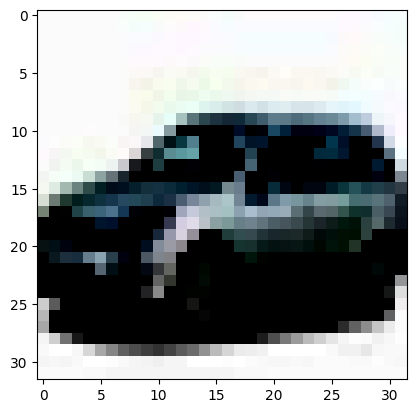


Worst Incorrect Prediction:
Confidence: 0.17200857400894165
Actual Index: 0 - Labels:  airplane
Predicted Index: 7 - Labels:  horse


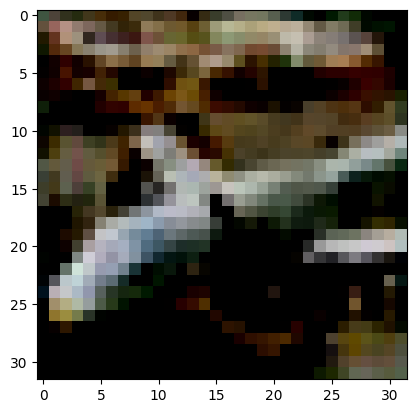

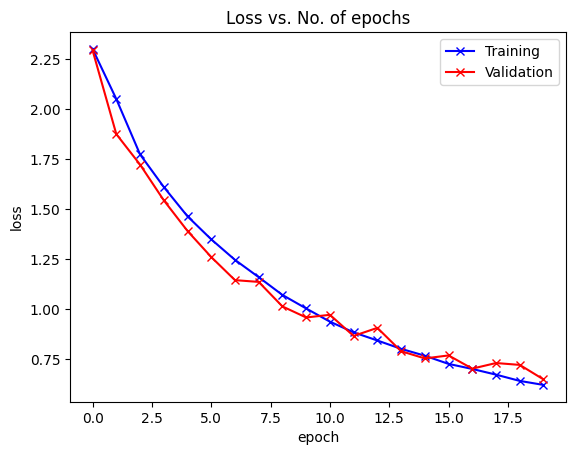

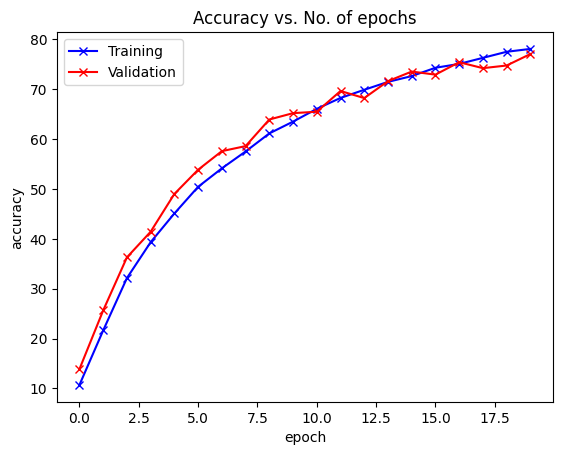

Test Loss: 0.6395, Test Accuracy: 77.58%


In [23]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)


# training model
alexnet_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(alexnet_results['train_loss'], alexnet_results['val_loss'])
plot_acc(alexnet_results['train_accuracy'], alexnet_results['val_accuracy'])
# Print Test Loss and Test Accuracy

print(f'Test Loss: {alexnet_results["test_loss"]:.4f}, Test Accuracy: {alexnet_results["test_accuracy"]:.2f}%')

### Train the network - VGG19

Model will be saved to: ./cifar10_vggnet19.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:06<00:00, 90.31it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 1/20, Train Loss: 2.3025, Train Acc: 10.48%, Val Loss: 2.3020, Val Acc: 10.27%, Time: 62.75s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 80.84it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 2/20, Train Loss: 2.2348, Train Acc: 15.15%, Val Loss: 2.0764, Val Acc: 18.84%, Time: 62.94s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 81.93it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 3/20, Train Loss: 1.9856, Train Acc: 20.08%, Val Loss: 1.9254, Val Acc: 19.64%, Time: 62.93s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 85.71it/s]


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 4/20, Train Loss: 1.9045, Train Acc: 22.11%, Val Loss: 1.8932, Val Acc: 23.75%, Time: 62.66s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 97.17it/s]


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 5/20, Train Loss: 1.8288, Train Acc: 26.60%, Val Loss: 1.7570, Val Acc: 30.20%, Time: 61.86s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 98.44it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 6/20, Train Loss: 1.7199, Train Acc: 31.64%, Val Loss: 1.6328, Val Acc: 35.38%, Time: 62.22s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 87.63it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 7/20, Train Loss: 1.6307, Train Acc: 35.78%, Val Loss: 1.5873, Val Acc: 37.31%, Time: 62.43s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 81.80it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 8/20, Train Loss: 1.5355, Train Acc: 39.96%, Val Loss: 1.4935, Val Acc: 42.61%, Time: 62.84s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 83.09it/s]


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 9/20, Train Loss: 1.4393, Train Acc: 45.22%, Val Loss: 1.3497, Val Acc: 50.51%, Time: 62.87s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 89.81it/s]


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 10/20, Train Loss: 1.3345, Train Acc: 50.68%, Val Loss: 1.2516, Val Acc: 52.91%, Time: 62.17s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 99.52it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 11/20, Train Loss: 1.2381, Train Acc: 54.57%, Val Loss: 1.1987, Val Acc: 56.51%, Time: 61.84s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.23it/s]


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 12/20, Train Loss: 1.1500, Train Acc: 57.71%, Val Loss: 1.1043, Val Acc: 59.53%, Time: 62.07s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 91.14it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 13/20, Train Loss: 1.0894, Train Acc: 59.87%, Val Loss: 1.0974, Val Acc: 60.11%, Time: 62.10s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 83.95it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 14/20, Train Loss: 1.0371, Train Acc: 62.09%, Val Loss: 0.9925, Val Acc: 63.49%, Time: 62.62s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 83.64it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 15/20, Train Loss: 0.9827, Train Acc: 64.44%, Val Loss: 1.0117, Val Acc: 63.56%, Time: 62.37s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 93.03it/s]


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 16/20, Train Loss: 0.9362, Train Acc: 66.48%, Val Loss: 0.9586, Val Acc: 67.29%, Time: 61.66s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 98.82it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 17/20, Train Loss: 0.8884, Train Acc: 68.72%, Val Loss: 0.8772, Val Acc: 69.29%, Time: 61.70s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.12it/s]


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 18/20, Train Loss: 0.8250, Train Acc: 71.48%, Val Loss: 0.8010, Val Acc: 72.80%, Time: 62.00s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 89.57it/s] 


Epoch 19/20, Train Loss: 0.7768, Train Acc: 73.60%, Val Loss: 0.8465, Val Acc: 72.71%, Time: 62.04s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 85.23it/s] 


Model improved and saved to ./cifar10_vggnet19.pth
Epoch 20/20, Train Loss: 0.7237, Train Acc: 75.24%, Val Loss: 0.8029, Val Acc: 74.22%, Time: 62.21s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 105.24it/s]


Test Loss: 0.8036, Test Acc: 74.70%
Test Acc on each class
Accuracy of class airplane : 75 %
Accuracy of class automobile : 91 %
Accuracy of class bird : 71 %
Accuracy of class cat : 55 %
Accuracy of class deer : 80 %
Accuracy of class dog : 59 %
Accuracy of class frog : 84 %
Accuracy of class horse : 72 %
Accuracy of class ship : 83 %
Accuracy of class truck : 72 %


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 87.12it/s] 


Best Correct Prediction:
Confidence: 1.0
Index: 1 - Labels:  automobile


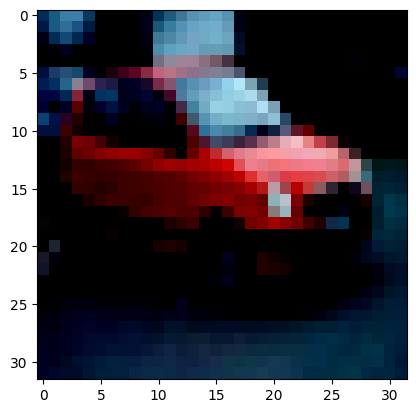


Worst Incorrect Prediction:
Confidence: 0.17770817875862122
Actual Index: 9 - Labels:  truck
Predicted Index: 7 - Labels:  horse


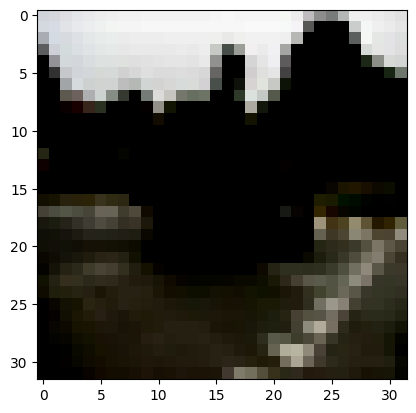

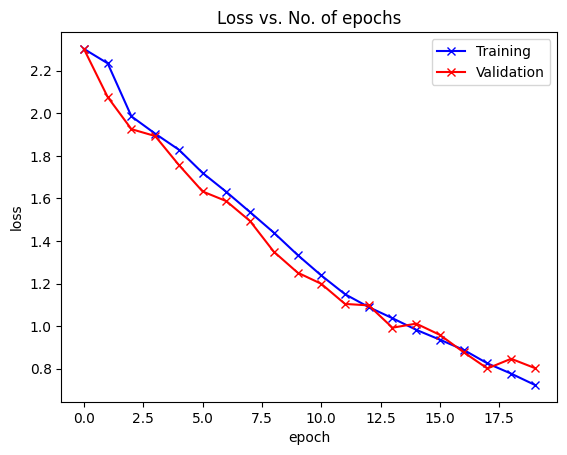

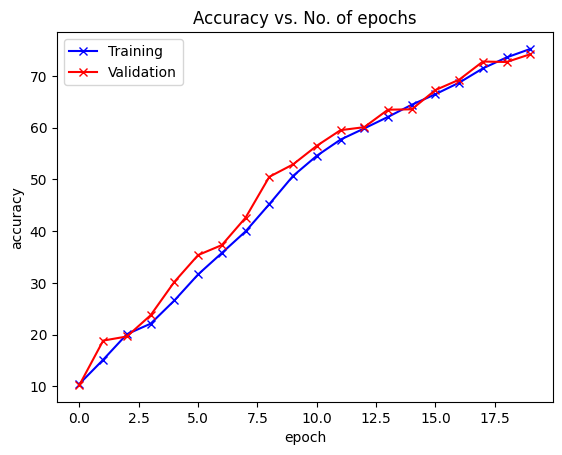

In [24]:
# individual configuration
vggnet19 = vgg19().to(device)
model_name = "vggnet19"
model = vggnet19

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
vggnet19_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(vggnet19_results['train_loss'], vggnet19_results['val_loss'])
plot_acc(vggnet19_results['train_accuracy'], vggnet19_results['val_accuracy'])

### Train the network - Resnet18

Model will be saved to: ./cifar10_resnet18.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:07<00:00, 79.77it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 1/20, Train Loss: 1.4844, Train Acc: 45.93%, Val Loss: 1.0802, Val Acc: 61.30%, Time: 74.42s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 86.33it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 2/20, Train Loss: 0.9947, Train Acc: 65.22%, Val Loss: 0.9224, Val Acc: 67.71%, Time: 73.96s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 90.95it/s] 


Model improved and saved to ./cifar10_resnet18.pth
Epoch 3/20, Train Loss: 0.7959, Train Acc: 72.16%, Val Loss: 0.7541, Val Acc: 74.36%, Time: 73.68s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 88.16it/s] 


Model improved and saved to ./cifar10_resnet18.pth
Epoch 4/20, Train Loss: 0.6807, Train Acc: 76.54%, Val Loss: 0.6208, Val Acc: 78.17%, Time: 74.14s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 79.80it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 5/20, Train Loss: 0.5993, Train Acc: 79.37%, Val Loss: 0.5924, Val Acc: 79.97%, Time: 74.38s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 81.05it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 6/20, Train Loss: 0.5417, Train Acc: 81.34%, Val Loss: 0.5616, Val Acc: 81.22%, Time: 74.38s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 82.41it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 7/20, Train Loss: 0.4937, Train Acc: 82.99%, Val Loss: 0.4662, Val Acc: 83.89%, Time: 74.34s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 92.37it/s]


Epoch 8/20, Train Loss: 0.4540, Train Acc: 84.40%, Val Loss: 0.4775, Val Acc: 83.15%, Time: 73.51s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 90.53it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 9/20, Train Loss: 0.4168, Train Acc: 85.66%, Val Loss: 0.4227, Val Acc: 85.32%, Time: 73.94s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 80.85it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 10/20, Train Loss: 0.3872, Train Acc: 86.62%, Val Loss: 0.4218, Val Acc: 85.38%, Time: 74.87s


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 77.78it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 11/20, Train Loss: 0.3637, Train Acc: 87.38%, Val Loss: 0.4089, Val Acc: 86.11%, Time: 74.80s


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 77.99it/s]


Epoch 12/20, Train Loss: 0.3404, Train Acc: 88.14%, Val Loss: 0.4115, Val Acc: 86.02%, Time: 75.35s


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 77.98it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 13/20, Train Loss: 0.3207, Train Acc: 89.00%, Val Loss: 0.3857, Val Acc: 87.07%, Time: 75.40s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 86.12it/s]


Epoch 14/20, Train Loss: 0.3033, Train Acc: 89.42%, Val Loss: 0.4355, Val Acc: 85.61%, Time: 74.44s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 90.25it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 15/20, Train Loss: 0.2825, Train Acc: 90.26%, Val Loss: 0.3805, Val Acc: 87.13%, Time: 74.57s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 91.51it/s] 


Model improved and saved to ./cifar10_resnet18.pth
Epoch 16/20, Train Loss: 0.2698, Train Acc: 90.65%, Val Loss: 0.3848, Val Acc: 87.20%, Time: 74.55s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 82.54it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 17/20, Train Loss: 0.2470, Train Acc: 91.41%, Val Loss: 0.3645, Val Acc: 87.76%, Time: 74.55s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 78.30it/s]


Epoch 18/20, Train Loss: 0.2348, Train Acc: 91.88%, Val Loss: 0.3771, Val Acc: 87.22%, Time: 75.06s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 79.72it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 19/20, Train Loss: 0.2193, Train Acc: 92.37%, Val Loss: 0.3223, Val Acc: 88.82%, Time: 74.90s


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 79.16it/s]


Model improved and saved to ./cifar10_resnet18.pth
Epoch 20/20, Train Loss: 0.2067, Train Acc: 92.84%, Val Loss: 0.3294, Val Acc: 89.02%, Time: 75.19s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 99.23it/s] 


Test Loss: 0.3264, Test Acc: 89.31%
Test Acc on each class
Accuracy of class airplane : 92 %
Accuracy of class automobile : 96 %
Accuracy of class bird : 80 %
Accuracy of class cat : 81 %
Accuracy of class deer : 92 %
Accuracy of class dog : 80 %
Accuracy of class frog : 91 %
Accuracy of class horse : 89 %
Accuracy of class ship : 94 %
Accuracy of class truck : 95 %


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 83.52it/s]


Best Correct Prediction:
Confidence: 1.0
Index: 9 - Labels:  truck


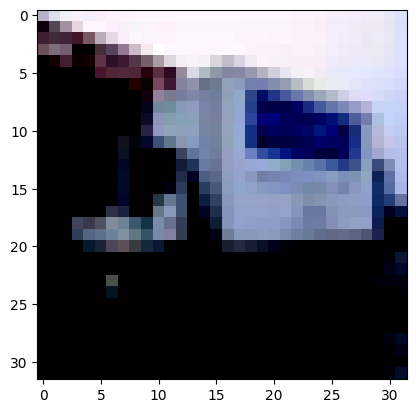


Worst Incorrect Prediction:
Confidence: 0.23619087040424347
Actual Index: 7 - Labels:  horse
Predicted Index: 6 - Labels:  frog


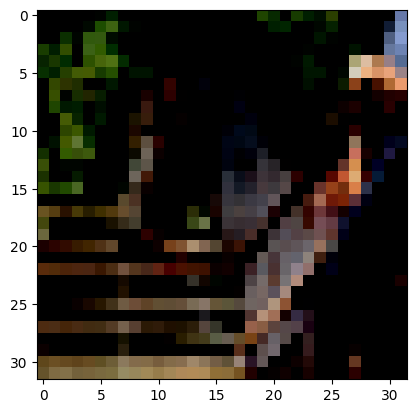

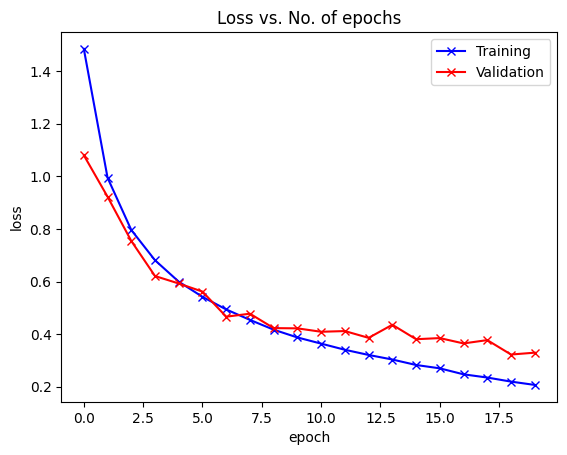

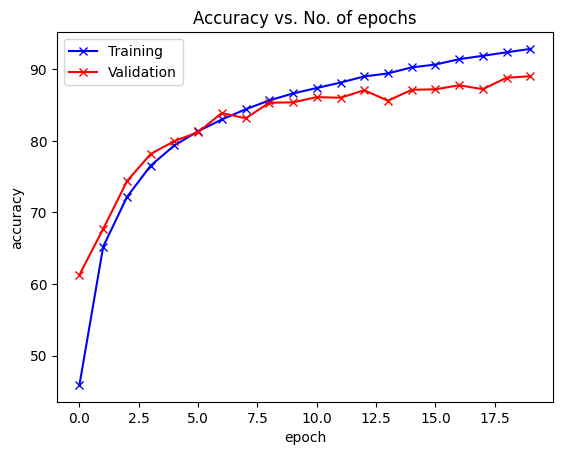

In [25]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet18_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet18_results['train_loss'], resnet18_results['val_loss'])
plot_acc(resnet18_results['train_accuracy'], resnet18_results['val_accuracy'])

### Train the network - Resnet34

Model will be saved to: ./cifar10_resnet34.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:09<00:00, 67.81it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 1/20, Train Loss: 1.5576, Train Acc: 43.56%, Val Loss: 1.1889, Val Acc: 57.20%, Time: 118.32s


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 70.39it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 2/20, Train Loss: 1.0590, Train Acc: 62.80%, Val Loss: 0.9531, Val Acc: 66.59%, Time: 116.99s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 66.53it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 3/20, Train Loss: 0.8365, Train Acc: 71.00%, Val Loss: 0.7395, Val Acc: 74.61%, Time: 116.92s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 65.32it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 4/20, Train Loss: 0.7066, Train Acc: 75.69%, Val Loss: 0.6442, Val Acc: 77.74%, Time: 118.02s


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 71.46it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 5/20, Train Loss: 0.6138, Train Acc: 78.87%, Val Loss: 0.6028, Val Acc: 80.12%, Time: 117.16s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 65.84it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 6/20, Train Loss: 0.5462, Train Acc: 81.53%, Val Loss: 0.5403, Val Acc: 81.40%, Time: 117.91s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.74it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 7/20, Train Loss: 0.4933, Train Acc: 83.16%, Val Loss: 0.5061, Val Acc: 82.89%, Time: 118.57s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 68.69it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 8/20, Train Loss: 0.4495, Train Acc: 84.58%, Val Loss: 0.4698, Val Acc: 83.80%, Time: 119.99s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.56it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 9/20, Train Loss: 0.4123, Train Acc: 85.90%, Val Loss: 0.4445, Val Acc: 84.79%, Time: 120.62s


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 71.64it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 10/20, Train Loss: 0.3776, Train Acc: 86.97%, Val Loss: 0.4163, Val Acc: 86.13%, Time: 118.11s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 64.90it/s]


Epoch 11/20, Train Loss: 0.3541, Train Acc: 87.89%, Val Loss: 0.4602, Val Acc: 84.14%, Time: 118.85s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 64.12it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 12/20, Train Loss: 0.3318, Train Acc: 88.70%, Val Loss: 0.3982, Val Acc: 86.27%, Time: 118.32s


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 71.88it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 13/20, Train Loss: 0.3085, Train Acc: 89.48%, Val Loss: 0.3771, Val Acc: 87.17%, Time: 117.18s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 65.28it/s]


Epoch 14/20, Train Loss: 0.2874, Train Acc: 90.00%, Val Loss: 0.4157, Val Acc: 86.35%, Time: 117.99s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 62.56it/s]


Epoch 15/20, Train Loss: 0.2752, Train Acc: 90.55%, Val Loss: 0.3741, Val Acc: 87.17%, Time: 119.71s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 68.22it/s]


Epoch 16/20, Train Loss: 0.2520, Train Acc: 91.20%, Val Loss: 0.3995, Val Acc: 86.56%, Time: 119.41s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.35it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 17/20, Train Loss: 0.2346, Train Acc: 91.95%, Val Loss: 0.3773, Val Acc: 87.93%, Time: 119.50s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 65.18it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 18/20, Train Loss: 0.2181, Train Acc: 92.44%, Val Loss: 0.3562, Val Acc: 88.25%, Time: 119.48s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.67it/s]


Model improved and saved to ./cifar10_resnet34.pth
Epoch 19/20, Train Loss: 0.2043, Train Acc: 92.80%, Val Loss: 0.3185, Val Acc: 89.40%, Time: 122.10s


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 67.51it/s]


Epoch 20/20, Train Loss: 0.1935, Train Acc: 93.37%, Val Loss: 0.3581, Val Acc: 88.12%, Time: 118.91s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 64.58it/s]


Test Loss: 0.3225, Test Acc: 89.58%
Test Acc on each class
Accuracy of class airplane : 92 %
Accuracy of class automobile : 96 %
Accuracy of class bird : 84 %
Accuracy of class cat : 77 %
Accuracy of class deer : 90 %
Accuracy of class dog : 82 %
Accuracy of class frog : 93 %
Accuracy of class horse : 92 %
Accuracy of class ship : 93 %
Accuracy of class truck : 92 %


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 64.71it/s]


Best Correct Prediction:
Confidence: 1.0
Index: 2 - Labels:  bird


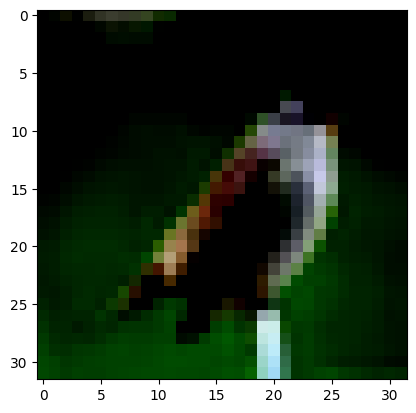


Worst Incorrect Prediction:
Confidence: 0.23890049755573273
Actual Index: 5 - Labels:  dog
Predicted Index: 3 - Labels:  cat


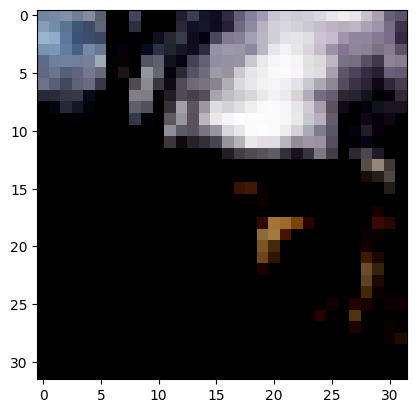

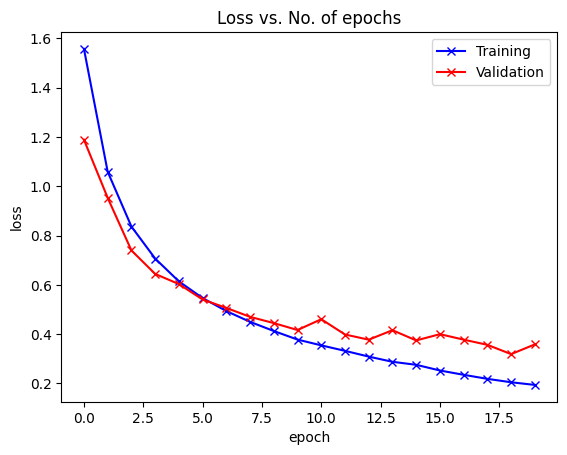

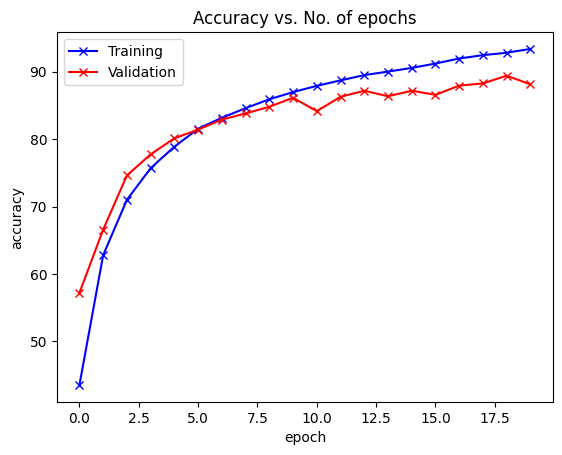

In [26]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet34_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )


# Plot the results
plot_loss(resnet34_results['train_loss'], resnet34_results['val_loss'])
plot_acc(resnet34_results['train_accuracy'], resnet34_results['val_accuracy'])

### Train the network - Resnet50

Model will be saved to: ./cifar10_resnet50.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.32it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 1/20, Train Loss: 1.7668, Train Acc: 36.37%, Val Loss: 1.3341, Val Acc: 52.01%, Time: 190.47s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.27it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 2/20, Train Loss: 1.2462, Train Acc: 55.57%, Val Loss: 1.0333, Val Acc: 63.47%, Time: 190.95s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.09it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 3/20, Train Loss: 1.0108, Train Acc: 64.48%, Val Loss: 0.8608, Val Acc: 70.13%, Time: 190.27s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.25it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 4/20, Train Loss: 0.8528, Train Acc: 70.34%, Val Loss: 0.7551, Val Acc: 72.94%, Time: 190.62s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.48it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 5/20, Train Loss: 0.7271, Train Acc: 74.80%, Val Loss: 0.7257, Val Acc: 75.41%, Time: 190.42s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.44it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 6/20, Train Loss: 0.6417, Train Acc: 78.00%, Val Loss: 0.5588, Val Acc: 80.76%, Time: 190.49s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.17it/s]


Epoch 7/20, Train Loss: 0.5736, Train Acc: 80.23%, Val Loss: 0.6290, Val Acc: 80.49%, Time: 189.67s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 53.67it/s]


Epoch 8/20, Train Loss: 0.5201, Train Acc: 82.21%, Val Loss: 0.5971, Val Acc: 80.24%, Time: 189.63s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 54.35it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 9/20, Train Loss: 0.4753, Train Acc: 83.72%, Val Loss: 0.5235, Val Acc: 82.81%, Time: 190.33s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.77it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 10/20, Train Loss: 0.4348, Train Acc: 84.90%, Val Loss: 0.4726, Val Acc: 83.75%, Time: 189.74s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.71it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 11/20, Train Loss: 0.4027, Train Acc: 86.06%, Val Loss: 0.4462, Val Acc: 84.81%, Time: 189.42s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.98it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 12/20, Train Loss: 0.3779, Train Acc: 86.80%, Val Loss: 0.4193, Val Acc: 85.73%, Time: 188.86s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.81it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 13/20, Train Loss: 0.3512, Train Acc: 87.97%, Val Loss: 0.4020, Val Acc: 86.48%, Time: 188.95s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.94it/s]


Epoch 14/20, Train Loss: 0.3292, Train Acc: 88.60%, Val Loss: 0.4445, Val Acc: 85.73%, Time: 189.09s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.86it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 15/20, Train Loss: 0.3094, Train Acc: 89.35%, Val Loss: 0.3694, Val Acc: 87.50%, Time: 188.59s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.46it/s]


Epoch 16/20, Train Loss: 0.2850, Train Acc: 90.19%, Val Loss: 0.3970, Val Acc: 86.70%, Time: 189.98s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.65it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 17/20, Train Loss: 0.2690, Train Acc: 90.56%, Val Loss: 0.3624, Val Acc: 88.02%, Time: 190.17s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 53.02it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 18/20, Train Loss: 0.2485, Train Acc: 91.37%, Val Loss: 0.3600, Val Acc: 88.20%, Time: 188.58s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.36it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 19/20, Train Loss: 0.2338, Train Acc: 91.77%, Val Loss: 0.3366, Val Acc: 88.66%, Time: 189.92s


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.84it/s]


Model improved and saved to ./cifar10_resnet50.pth
Epoch 20/20, Train Loss: 0.2147, Train Acc: 92.55%, Val Loss: 0.3344, Val Acc: 89.19%, Time: 189.63s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.79it/s]


Test Loss: 0.3426, Test Acc: 89.23%
Test Acc on each class
Accuracy of class airplane : 91 %
Accuracy of class automobile : 96 %
Accuracy of class bird : 84 %
Accuracy of class cat : 76 %
Accuracy of class deer : 89 %
Accuracy of class dog : 84 %
Accuracy of class frog : 89 %
Accuracy of class horse : 91 %
Accuracy of class ship : 95 %
Accuracy of class truck : 92 %


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.13it/s]


Best Correct Prediction:
Confidence: 1.0
Index: 9 - Labels:  truck


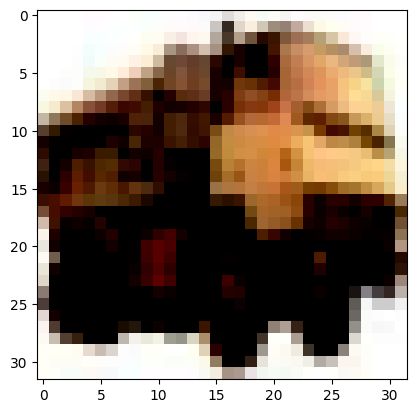


Worst Incorrect Prediction:
Confidence: 0.24715209007263184
Actual Index: 4 - Labels:  deer
Predicted Index: 0 - Labels:  airplane


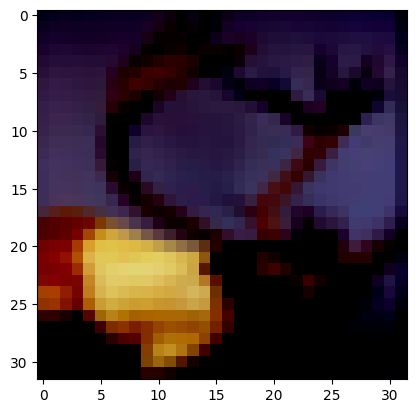

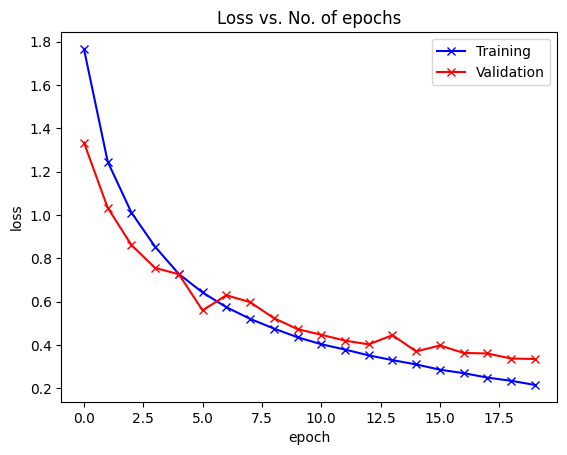

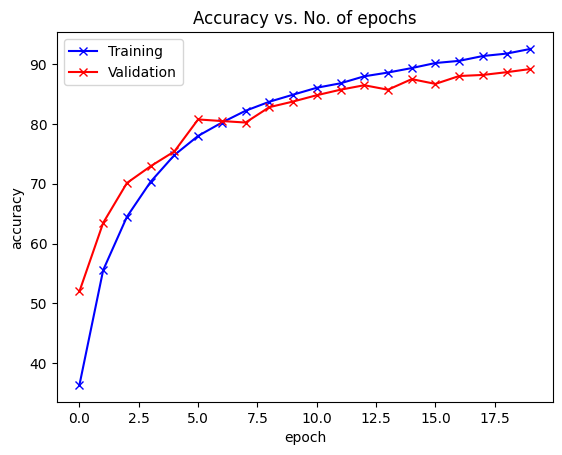

In [27]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet50_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet50_results['train_loss'], resnet50_results['val_loss'])
plot_acc(resnet50_results['train_accuracy'], resnet50_results['val_accuracy'])

## compare the accuracy on each class for each model

<ipython-input-28-71456af87f88>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


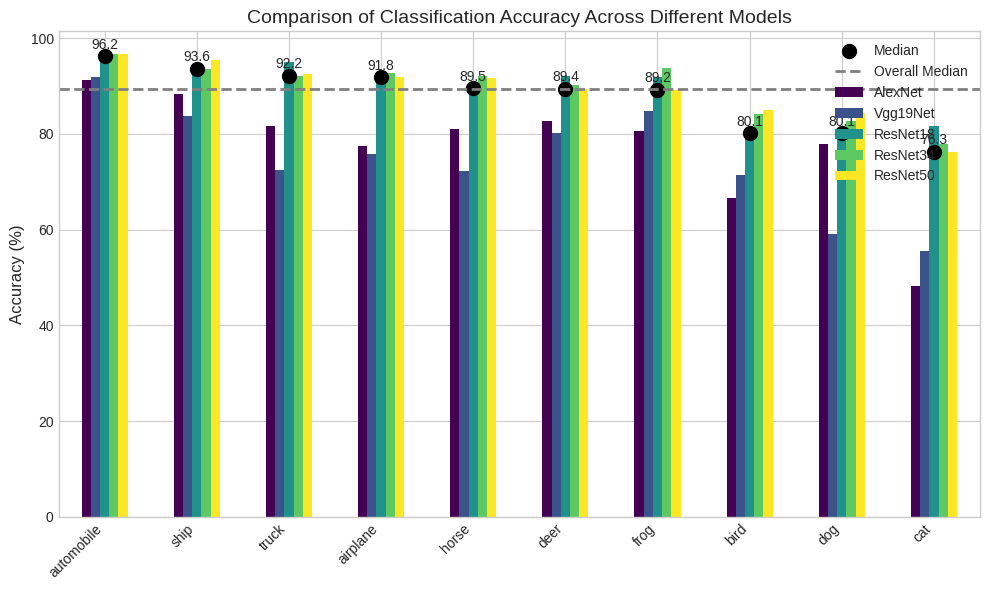

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_models(class_results_dict):
    # Create a DataFrame from the dictionary of class results
    df = pd.DataFrame(class_results_dict)

    # Calculate the median for all results
    df['Median'] = df.median(axis=1)

    # Sort the dataframe based on the median values
    df = df.sort_values(by='Median', ascending=False)

    # Select the best 5 and worst 5 classes
    best_5 = df.head(5)
    worst_5 = df.tail(5)

    # Combine best 5 and worst 5
    selected_classes = pd.concat([best_5, worst_5])

    # Plotting
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plot for models
    colors = plt.cm.viridis(np.linspace(0, 1, len(class_results_dict)))
    selected_classes.drop(columns='Median').plot(kind='bar', ax=ax, color=colors)

    # Scatter plot for median values
    x_values = np.arange(len(selected_classes))
    ax.scatter(x_values, selected_classes['Median'], color='black', s=100, label='Median')

    # Horizontal line for overall median
    overall_median = df['Median'].median()
    ax.axhline(overall_median, color='gray', linewidth=2, linestyle='--', label='Overall Median')

    # Annotating the median values on the chart
    for i, value in enumerate(selected_classes['Median']):
        ax.text(i, value+1, f'{value:.1f}', ha='center', va='bottom', fontsize=10)

    # Setting labels and title
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Comparison of Classification Accuracy Across Different Models', fontsize=14)
    ax.legend()

    # Setting x-ticks
    ax.set_xticks(np.arange(len(selected_classes)))
    ax.set_xticklabels(selected_classes.index, rotation=45, ha='right', fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example class results
class_results_dict = {
    'AlexNet': alexnet_results['class_results'],
    'Vgg19Net': vggnet19_results['class_results'],
    'ResNet18': resnet18_results['class_results'],
    'ResNet34': resnet34_results['class_results'],
    'ResNet50': resnet50_results['class_results']
}

# Compare the models
compare_models(class_results_dict)

## compare the best image and worst confident on each class for each model

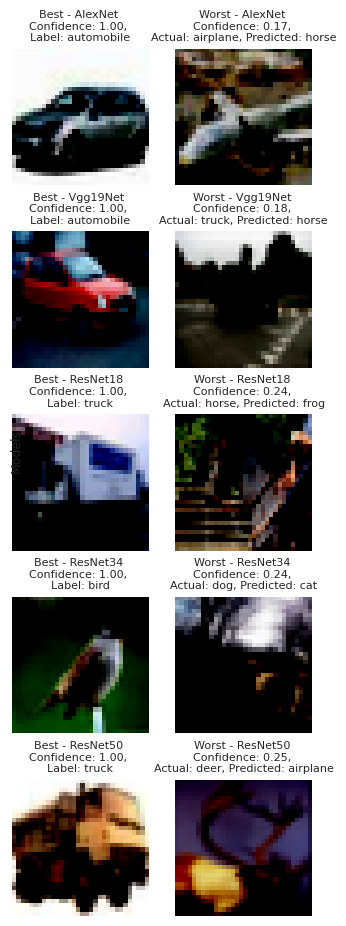

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_best_worst_predictions(model_histories, classes):
    # Set the style for the plot
    sns.set_style("whitegrid")

    num_models = len(model_histories)
    fig, axs = plt.subplots(num_models, 2, figsize=(10, 5 * num_models))

    for i, (model_name, results) in enumerate(model_histories.items()):
        # Best Prediction
        best_correct = results['best_correct'][0]
        image = best_correct['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f"Best Prediction - {model_name} \n(Confidence: {best_correct['confidence'].item():.2f}, Label: {classes[best_correct['label']]})", fontsize=12)
        axs[i, 0].axis('off')

        # Worst Prediction
        worst_incorrect = results['worst_incorrect'][0]
        image = worst_incorrect['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 1].imshow(image)
        axs[i, 1].set_title(f"Worst Prediction - {model_name} \n(Confidence: {worst_incorrect['confidence'].item():.2f}, Actual: {classes[worst_incorrect['label']]}, Predicted: {classes[worst_incorrect['predicted_label']]})", fontsize=12)
        axs[i, 1].axis('off')

    # Adding labels and title
    fig.text(0.04, 0.5, 'Models', va='center', rotation='vertical', fontsize=14)
    fig.text(0.5, 0.04, 'Predictions', ha='center', fontsize=14)
    plt.suptitle('Best and Worst Predictions Across Models', fontsize=16, y=1.02)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0.4)

    plt.show()

def plot_best_worst_predictions(model_histories, classes):
    sns.set_style("whitegrid")

    num_models = len(model_histories)
    fig_width = 3.3  # inches
    fig_height = 2 * num_models  # Adjust the height based on the number of models
    fig, axs = plt.subplots(num_models, 2, figsize=(fig_width, fig_height))

    for i, (model_name, results) in enumerate(model_histories.items()):
        # Best Prediction
        best_correct = results['best_correct'][0]
        image = best_correct['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f"Best - {model_name} \nConfidence: {best_correct['confidence'].item():.2f}, \nLabel: {classes[best_correct['label']]}", fontsize=8)
        axs[i, 0].axis('off')

        # Worst Prediction
        worst_incorrect = results['worst_incorrect'][0]
        image = worst_incorrect['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 1].imshow(image)
        axs[i, 1].set_title(f"Worst - {model_name} \nConfidence: {worst_incorrect['confidence'].item():.2f}, \nActual: {classes[worst_incorrect['label']]}, Predicted: {classes[worst_incorrect['predicted_label']]}", fontsize=8)
        axs[i, 1].axis('off')

    # Adding labels and title
    fig.text(0.04, 0.5, 'Models', va='center', rotation='vertical', fontsize=9)
    # plt.suptitle('Best and Worst Predictions', fontsize=10, y=1.02)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, wspace=0.2, hspace=0.05)

    plt.show()

# Assuming model_results_1, model_results_2, and model_results_3 are dictionaries that hold the results from different models
model_histories = {
    'AlexNet': alexnet_results,
    'Vgg19Net': vggnet19_results,
    'ResNet18': resnet18_results,
    'ResNet34': resnet34_results,
    'ResNet50': resnet50_results
}
plot_best_worst_predictions(model_histories, classes)